In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
! pip install gym
from gym import Env
from gym.spaces import Discrete, Box

In [2]:
class GridWorldEnv(Env):
    def __init__(self):
        # Define the grid size and states
        self.grid_size = 5
        self.state_space = [(i, j) for i in range(self.grid_size) for j in range(self.grid_size)]
        self.action_space = Discrete(4)  # Actions: 0=Up, 1=Right, 2=Down, 3=Left
        self.observation_space = Box(low=0, high=self.grid_size-1, shape=(2,), dtype=int)

        # Define rewards
        self.rewards = {  # Example reward positions and values
            (0, 2): -5,
            (2, 3): -6,
            (2, 1): +5,
            (4, 2): +7,
            (4, 4): +10  # Goal state with the maximum reward
        }

        # Initial state
        self.state = (0, 0)
        self.goal_state = (4, 4)

    def reset(self):
        self.state = (0, 0)
        return np.array(self.state, dtype=int)

    def step(self, action):
        row, col = self.state

        # Update the position based on the action
        if action == 0 and row > 0:         # Up
            row -= 1
        elif action == 1 and col < self.grid_size - 1:  # Right
            col += 1
        elif action == 2 and row < self.grid_size - 1:  # Down
            row += 1
        elif action == 3 and col > 0:       # Left
            col -= 1

        self.state = (row, col)

        # Calculate reward
        reward = self.rewards.get(self.state, 0)
        done = self.state == self.goal_state

        return np.array(self.state, dtype=int), reward, done, {}

    def render(self):
        grid = np.zeros((self.grid_size, self.grid_size))
        for position, reward in self.rewards.items():
            grid[position] = reward
        grid[self.state] = 1  # Mark agent's position
        plt.imshow(grid, cmap='coolwarm', origin='upper')
        plt.colorbar()
        plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# Define the SARSA Agent class
class SARSA_Agent:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.env = env
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration-exploitation parameter
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_table = self.init_q_table()

    def init_q_table(self):
        return np.zeros((self.env.grid_size, self.env.grid_size, self.env.action_space.n))

    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()
        row, col = state
        return np.argmax(self.q_table[row, col])

    def train(self, num_episodes=500, max_timesteps=100):
        rewards_per_episode = []
        epsilon_values = []
        # Save initial Q-table before training starts
        initial_q_table = np.copy(self.q_table)
        for episode in range(num_episodes):
            state = self.env.reset()
            action = self.choose_action(state)
            total_reward = 0
            for _ in range(max_timesteps):
                next_state, reward, done, _ = self.env.step(action)
                next_action = self.choose_action(next_state)
                row, col = state
                next_row, next_col = next_state
                self.q_table[row, col, action] += self.alpha * (
                    reward + self.gamma * self.q_table[next_row, next_col, next_action] - self.q_table[row, col, action]
                )
                state = next_state
                action = next_action
                total_reward += reward
                if done:
                    break
            rewards_per_episode.append(total_reward)
            epsilon_values.append(self.epsilon)
            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
        return rewards_per_episode, epsilon_values, initial_q_table

    def evaluate_greedy_policy(self, num_episodes=10, max_timesteps=100):
        rewards_per_episode = []
        for _ in range(num_episodes):
            state = self.env.reset()
            total_reward = 0
            for _ in range(max_timesteps):
                row, col = state
                action = np.argmax(self.q_table[row, col])
                state, reward, done, _ = self.env.step(action)
                total_reward += reward
                if done:
                    break
            rewards_per_episode.append(total_reward)
        return rewards_per_episode


Initial Q-table:
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]

Trained Q-table:
[[[ 1.23095262e+02  3.12749652e+01  3.37458860e+02  1.14207792e+02]
  [-1.33513436e+00 -2.97051504e+00  9.77029444e+01  9.92186956e+00]
  [-4.45009920e+00 -1.45004880e+00  1.25019809e+01  1.58507526e+00]
  [-1.67563727e+00 -5.49295869e-01 -1.70708443e+00 -4.57966879e+00]
  [-5.80144327e-01 -6.22052401e-01 -5.40541575e-01 -1.36352407e+00]]

 [[ 6.60265145e+01  1.25636272e+02  3.57132045e+02  1.02330766e+02]
  [ 5.41781131e+00  1.38880448e+01  2.84461980e+02  4.90554653e+01]
  [-5.30797585e+00 -1.35015351e+00  7.72057537e+01  1.13071428e+01]
  [-1.459

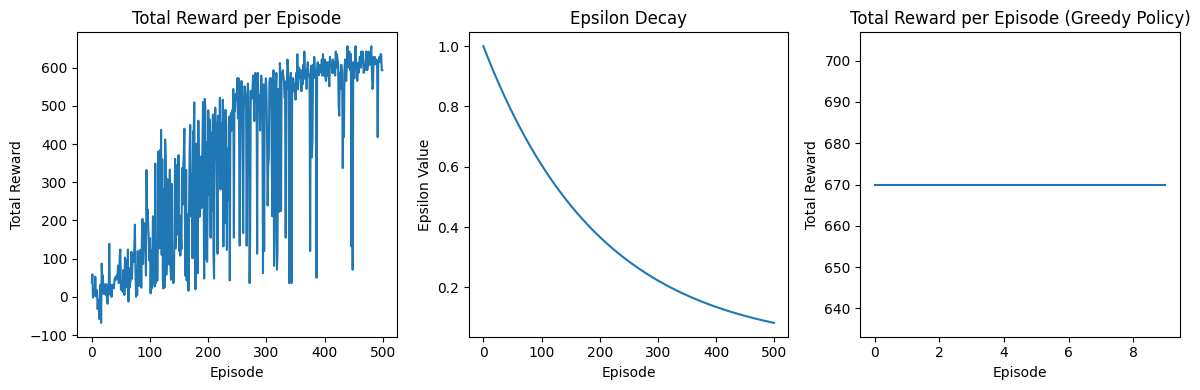

array([[[ 1.23095262e+02,  3.12749652e+01,  3.37458860e+02,
          1.14207792e+02],
        [-1.33513436e+00, -2.97051504e+00,  9.77029444e+01,
          9.92186956e+00],
        [-4.45009920e+00, -1.45004880e+00,  1.25019809e+01,
          1.58507526e+00],
        [-1.67563727e+00, -5.49295869e-01, -1.70708443e+00,
         -4.57966879e+00],
        [-5.80144327e-01, -6.22052401e-01, -5.40541575e-01,
         -1.36352407e+00]],

       [[ 6.60265145e+01,  1.25636272e+02,  3.57132045e+02,
          1.02330766e+02],
        [ 5.41781131e+00,  1.38880448e+01,  2.84461980e+02,
          4.90554653e+01],
        [-5.30797585e+00, -1.35015351e+00,  7.72057537e+01,
          1.13071428e+01],
        [-1.45991635e+00, -3.94938024e-01, -5.36135741e+00,
         -1.88903202e-01],
        [-4.55589983e-01, -2.79674349e-01,  2.37747557e+00,
         -1.36795114e+00]],

       [[ 1.03641595e+02,  3.82057866e+02,  1.37056272e+02,
          1.82635038e+02],
        [ 1.25495145e+02,  1.64486207e+

In [4]:
# Initialize environment and SARSA agent
env = GridWorldEnv()
agent = SARSA_Agent(env)

# Train the agent
num_episodes = 500
rewards, epsilons, initial_q_table = agent.train(num_episodes=num_episodes)

# Evaluate greedy policy
greedy_rewards = agent.evaluate_greedy_policy()

# Print Initial and Trained Q-tables
print("Initial Q-table:")
print(initial_q_table)
print("\nTrained Q-table:")
print(agent.q_table)

# Plotting results
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(rewards)
plt.title('Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.subplot(1, 3, 2)
plt.plot(epsilons)
plt.title('Epsilon Decay')
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.subplot(1, 3, 3)
plt.plot(greedy_rewards)
plt.title('Total Reward per Episode (Greedy Policy)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.tight_layout()
plt.show()

# Display initial and trained Q-tables
agent.q_table

Gamma: 0.9, Epsilon Decay: 0.995, Avg Reward: 358.67
Gamma: 0.9, Epsilon Decay: 0.99, Avg Reward: 504.22
Gamma: 0.9, Epsilon Decay: 0.98, Avg Reward: 584.82
Gamma: 0.95, Epsilon Decay: 0.995, Avg Reward: 357.17
Gamma: 0.95, Epsilon Decay: 0.99, Avg Reward: 508.34
Gamma: 0.95, Epsilon Decay: 0.98, Avg Reward: 226.45
Gamma: 0.99, Epsilon Decay: 0.995, Avg Reward: 359.17
Gamma: 0.99, Epsilon Decay: 0.99, Avg Reward: 501.22
Gamma: 0.99, Epsilon Decay: 0.98, Avg Reward: 582.02
Best Hyperparameters - Gamma: 0.9, Epsilon Decay: 0.98 with Avg Reward: 584.82


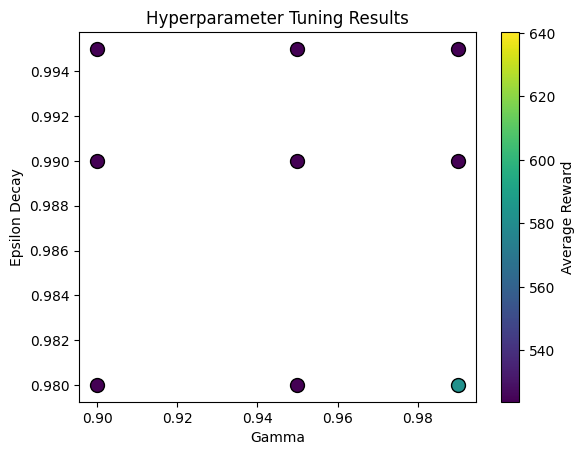

In [5]:
def tune_hyperparameters(env, gamma_values, epsilon_decay_values, num_episodes=500):
    results = {}

    for gamma in gamma_values:
        for epsilon_decay in epsilon_decay_values:
            # Initialize agent with specific gamma and epsilon decay
            agent = SARSA_Agent(env, gamma=gamma, epsilon_decay=epsilon_decay)
            total_rewards, _, _ = agent.train(num_episodes=num_episodes)
            avg_reward = np.mean(total_rewards)
            results[(gamma, epsilon_decay)] = avg_reward
            print(f"Gamma: {gamma}, Epsilon Decay: {epsilon_decay}, Avg Reward: {avg_reward:.2f}")

    return results

# Define the range of values to test
gamma_values = [0.9, 0.95, 0.99]
epsilon_decay_values = [0.995, 0.99, 0.98]

# Initialize environment
env = GridWorldEnv()

# Run hyperparameter tuning
results = tune_hyperparameters(env, gamma_values, epsilon_decay_values)

# Identify the best combination
best_params = max(results, key=results.get)
print(f"Best Hyperparameters - Gamma: {best_params[0]}, Epsilon Decay: {best_params[1]} with Avg Reward: {results[best_params]:.2f}")

# Plot results for visual analysis
plt.figure()
for (gamma, epsilon_decay), reward in results.items():
    plt.scatter(gamma, epsilon_decay, s=100, c=reward, cmap='viridis', edgecolors='k')
plt.colorbar(label='Average Reward')
plt.xlabel('Gamma')
plt.ylabel('Epsilon Decay')
plt.title('Hyperparameter Tuning Results')
plt.show()

**The Best Model Evaluation**

Initial Q-table:
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]

Trained Q-table:
[[[ 1.82245181e+01  2.70779536e+00  4.43758941e+01  3.34658211e+00]
  [ 2.09289801e+00 -4.64219196e+00  1.04329581e+01  2.76444805e-01]
  [-1.74604143e+00 -3.34532834e-01 -2.40804436e-01 -3.78792652e-01]
  [-5.41239389e-01 -5.47161600e-02 -3.05012213e-01 -3.58051711e+00]
  [-6.59260225e-02 -3.42125690e-02 -1.88350191e-02 -5.07267196e-01]]

 [[ 1.14457373e+01  1.40848253e+01  4.95392091e+01  4.21500431e+00]
  [ 4.28379782e-01  4.03851691e+00  3.20811299e+01  3.24250389e+00]
  [-3.99411502e+00 -2.23633618e-01  2.06989580e+00  1.15338270e+01]
  [-1.746

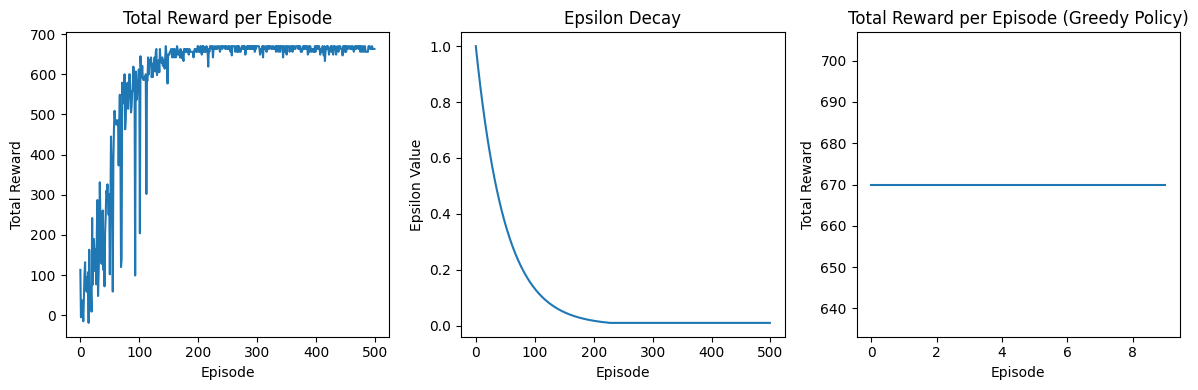

array([[[ 1.82245181e+01,  2.70779536e+00,  4.43758941e+01,
          3.34658211e+00],
        [ 2.09289801e+00, -4.64219196e+00,  1.04329581e+01,
          2.76444805e-01],
        [-1.74604143e+00, -3.34532834e-01, -2.40804436e-01,
         -3.78792652e-01],
        [-5.41239389e-01, -5.47161600e-02, -3.05012213e-01,
         -3.58051711e+00],
        [-6.59260225e-02, -3.42125690e-02, -1.88350191e-02,
         -5.07267196e-01]],

       [[ 1.14457373e+01,  1.40848253e+01,  4.95392091e+01,
          4.21500431e+00],
        [ 4.28379782e-01,  4.03851691e+00,  3.20811299e+01,
          3.24250389e+00],
        [-3.99411502e+00, -2.23633618e-01,  2.06989580e+00,
          1.15338270e+01],
        [-1.74660584e-01, -2.11764563e-02, -3.87021001e+00,
          1.37530530e+00],
        [-4.92153212e-02, -3.18880584e-02,  9.50829632e-02,
         -3.99583047e-01]],

       [[ 1.19285619e+01,  5.48741735e+01,  8.74479471e+00,
          1.52017446e+01],
        [ 9.92635539e+00,  1.25570005e+

In [7]:
# Initialize environment and SARSA agent
env = GridWorldEnv()
agent = SARSA_Agent(env, gamma=0.9, epsilon_decay=0.98 )

# Train the agent
num_episodes = 500
rewards, epsilons, initial_q_table = agent.train(num_episodes=num_episodes)

# Evaluate greedy policy
greedy_rewards = agent.evaluate_greedy_policy()

# Print Initial and Trained Q-tables
print("Initial Q-table:")
print(initial_q_table)
print("\nTrained Q-table:")
print(agent.q_table)

# Plotting results
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(rewards)
plt.title('Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.subplot(1, 3, 2)
plt.plot(epsilons)
plt.title('Epsilon Decay')
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.subplot(1, 3, 3)
plt.plot(greedy_rewards)
plt.title('Total Reward per Episode (Greedy Policy)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.tight_layout()
plt.show()

# Display initial and trained Q-tables
agent.q_table